In [1]:
import pandas as pd
import numpy as np
import QuantLib as ql
from datetime import datetime
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import bisect
from scipy.stats import norm
from sklearn import decomposition
from numpy.linalg import norm
from scipy.stats import norm

# Caso 3

**Un portafolio de inversión consiste de 1 millón de dólares de facial colocados en la nota del tesoro con CUSIP 91282CGU9 y de 1.5 millones en la nota con CUSIP 91282CGS4. La descripción de los instrumentos se brinda en los documentos adjuntos. Note que las notas del tesoro pagan intereses semestralmente. Suponga que la fecha de análisis es el día de la emisión de los instrumentos, o sea el 31 de marzo de 2023.**

**Se adjunta, además, un histórico de curvas de rendimiento cero cupón calculadas por el Banco de la Reserva Federal.**

## Inciso a)

**a) Analice el riesgo del portafolio por medio de un enfoque paramétrico, usando una aproximación delta normal.**

Primero vamos a analizar el bono de CUSIP 91282CGU9.

In [2]:
precio1 = 99.849511
tasa_cupon_1 = 0.03875
periodicidad = 2 #Ambas notas tienen la misma periodicidad

fecha_emision = pd.to_datetime("2023-03-31") # Asumiendo la misma fecha de emisión para ambos instrumentos
fecha_vencimiento = pd.to_datetime("2025-03-31")
fecha_calculo = pd.to_datetime("2023-03-31") # Es la misma que la fecha de emisión

# Se van a definir las mismas fechas pero con QuantLib para definir las características del bono más adelante
fecha_calc_ql = ql.Date(fecha_calculo.day,fecha_calculo.month,fecha_calculo.year)
fecha_vencimiento_ql = ql.Date(fecha_vencimiento.day, fecha_vencimiento.month, fecha_vencimiento.year)
fecha_emision_ql = ql.Date(fecha_emision.day, fecha_emision.month, fecha_emision.year)

Ahora se van a definir la fecha de evaluación (fecha de emisión definida en el chunk anterior) del bono en el entorno de $\texttt{QuantLib}$ mediante un objeto de tipo $\texttt{Date}$.

In [3]:
ql.Settings.instance().evaluationDate = ql.Date(fecha_calculo.day,fecha_calculo.month,fecha_calculo.year)

Se va a crear un calendario para los flujos de pago que sirva en los cálculos financieros necesarios. Para esto primero se usa la función $\texttt{Bespoke}$ y luego se definen los sábados y domingos como días no hábiles. Esto es importante porque si un pago de cupón cae en uno de estos días, el pago se moverá al siguiente día hábil (se especifica con la función $\texttt{ql.Following}$). 

Después, con la función $\texttt{ql.DateGeneration.Backward}$ se establece que las fechas se generarán hacia atrás desde la fecha de vencimiento del bono hasta la fecha de emisión

In [4]:
qlCalendar = ql.BespokeCalendar("United States")
qlCalendar.addWeekend(ql.Sunday)
qlCalendar.addWeekend(ql.Saturday)
qlConvencion = ql.Following # Para no generar pagos en días no hábiles como sábados o domingos

qlPeriodicidad = ql.Period(periodicidad)
dateGeneration = ql.DateGeneration.Backward
monthEnd = False # Para que los pagos no se den a fin de mes si no en las fechas establecidas según la periodicidad

Ahora con todas estas especificidades se puede generar un calendario de pagos como se muestra a continuación

In [5]:
calendario = ql.Schedule(fecha_emision_ql,fecha_vencimiento_ql, qlPeriodicidad, 
                         qlCalendar,qlConvencion,qlConvencion,dateGeneration,monthEnd)

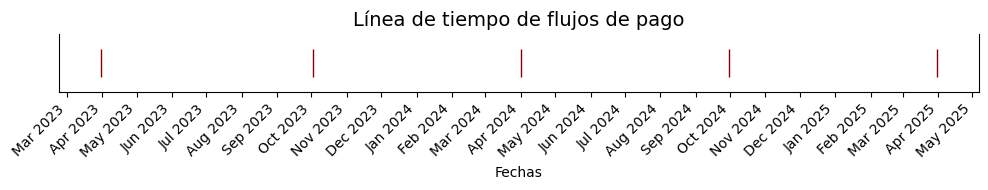

In [6]:
def ql_to_datetime(ql_date):
    return datetime(ql_date.year(), ql_date.month(), ql_date.dayOfMonth())

fechas = [ql_to_datetime(fecha) for fecha in calendario]

fig, ax = plt.subplots(figsize=(10, 2))

ax.plot(fechas, [0] * len(fechas), "|", markersize=20, color='darkred')
ax.xaxis.set_major_locator(mdates.MonthLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.yticks([])  
plt.ylim(-1, 1)
ax.spines['top'].set_visible(False)
plt.title("Línea de tiempo de flujos de pago", fontsize=14)
plt.xlabel("Fechas")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

A continuación se can a definir los parámetros relacionados al flujo de pagos: el conteo de días, la capitalización de intereses, la frecuencia de los pagos y los días de liquidación.

In [7]:
dayCount = ql.Thirty360(ql.Thirty360.BondBasis) # Para usar meses de 30 días en un año de 360 días convencial.
compound_type = ql.Compounded # Para asegurarse de capitalizar los intereses
frequency = ql.Semiannual # Recordando que la periodicidad es 2
settlementDays = 0 # La liquidación ocurre en la misma fecha de evaluación

Además se calcula la tasa de interés del bono

In [8]:
interes = ql.InterestRate(tasa_cupon_1, dayCount, compound_type,frequency)
print(interes)

3.875000 % 30/360 (Bond Basis) Semiannual compounding


Ahora que se conoce la tasa se va a crear un bono de tasa fija con todas las características definidas anteriormente haciendo uso del objeto $\texttt{FixedRateBond}$ del paquete $\texttt{QuantLib}$

In [9]:
bono1 = ql.FixedRateBond(settlementDays, 100, calendario, [tasa_cupon_1], dayCount)

El siguiente paso es calcular y mostrar todos los flujos de pago del bono (incluyendo los pagos de cupones y el reembolso del capital (valor nominal) al vencimiento)

In [10]:
cf = bono1.cashflows() # Devuelve todos los flujos de efectivo
fechas = [item.date() for item in cf] # Se extraen las fechas para realizar los pagos
montos = [item.amount() for item in cf] # Se extraen los montos de los pagos

pd.DataFrame({"Fechas":fechas, "Montos": montos})

,Fechas,Montos
0,"October 2nd, 2023",1.959028
1,"April 1st, 2024",1.926736
2,"September 30th, 2024",1.926736
3,"March 31st, 2025",1.937500
4,"March 31st, 2025",100.000000


Ahora que se tienen los flujos de pago ya se puede calcular la tasa de rendimiento (yield) del bono. 

In [11]:
yield_rate = bono1.bondYield(precio1,dayCount,compound_type,frequency)

 A continuación se busca la tasa de interés que tiene en cuenta el rendimiento del bono, con las reglas de capitalización y conteo de días correspondientes.

In [12]:
interes_rend = ql.InterestRate(yield_rate,dayCount,compound_type,frequency)

Con esta información podemos calcular por fin la duración modificada para estudiar la sensibilidad del precio del bono a los cambios de la tasa de interés

In [13]:
duracionMod1 = ql.BondFunctions.duration(bono1,interes_rend,ql.Duration.Modified)

Ahora, se va a cargar la curva cero cupón proporcionados y ajustarlos a las fechas de pago correspondientes al bono

In [14]:
tasa_zero_cupon = pd.read_excel("CurvaActualizadaCaso3.xlsx") # Carga de datos
tasa_zero_cupon.set_index('Date', inplace=True) # Se seleccionan las fechas como índice
curva_actual = tasa_zero_cupon.iloc[-1,:] # Se seleccionan todas las columnas de la última fila

In [15]:
tasa_actual = curva_actual.values # tasas de interés para diferentes plazos de vencimiento
plazos = curva_actual.index.values # corresponde a los plazos en días para las tasas anteriores
plazos_numeros = [int(re.search(r'\d+', plazo).group()) for plazo in plazos]
plazos_numeros_array = np.array(plazos_numeros)

df_tasas = pd.DataFrame({
    'Plazo (días)': plazos_numeros_array,
    'Tasa (%)': tasa_actual * 100  
})

df_tasas

,Plazo (días),Tasa (%)
0,1,5.343767
1,30,5.259337
2,90,5.097032
3,180,4.881758
4,360,4.535153
5,720,4.079181
6,1080,3.817697
7,1800,3.579613
8,2520,3.510458
9,3600,3.521748


Se establece la estructura de plazos para que pueda ser utilizada en los cálculos de valoración y análisis de sensibilidad de los bonos

In [16]:
# Calcular la representación de la curva cero cupón
# Se suman las fechas para obtener las fechas en las que se aplican las tasas cero cupón.
curva_ql0 = ql.ZeroCurve(fecha_calc_ql+plazos_numeros_array,tasa_actual,ql.Thirty360(ql.Thirty360.BondBasis))
curva_ql = ql.YieldTermStructureHandle(curva_ql0)

# Ajusta la curva de tasas agregando un spread (en este caso, cero)
estructura_plazos = ql.ZeroSpreadedTermStructure(curva_ql,ql.QuoteHandle(ql.SimpleQuote(0)),ql.Compounded,ql.Semiannual,dayCount)

Establecer el motor de valoración del bono utilizando la curva de rendimiento que creaste anteriormente

In [17]:
pricing_engine = ql.DiscountingBondEngine(ql.RelinkableYieldTermStructureHandle(estructura_plazos))

Cálculo del valor presente neto (NPV) del bono utilizando el motor de valoración previamente configurado, es decir que se obtendrá el precio del bono en la fecha de cálculo, basado en la curva de tasas cero cupón proporcionada para el ejercicio

In [24]:
bono1.setPricingEngine(pricing_engine)

print('Valor Presente Neto (NPV) del bono:', bono1.NPV())

Valor Presente Neto (NPV) del bono: 99.52623809960488


Ahora se va a usar la función que calcula el precio del bono en función de un spread dado

In [25]:
def Precio1(spread):
    estructura_plazos = ql.ZeroSpreadedTermStructure(curva_ql,ql.QuoteHandle(ql.SimpleQuote(spread)),ql.Compounded,ql.Semiannual,dayCount)
    pricing_engine = ql.DiscountingBondEngine(ql.RelinkableYieldTermStructureHandle(estructura_plazos))

    bono1.setPricingEngine(pricing_engine)
    return bono1.NPV()

Con la función bisect de SciPy se va a encontrar el spread que iguala el precio de mercado de un bono al precio calculado del mismo bono utilizando la función

In [26]:
def ErrorPrecio1(spread):
    return precio1-Precio1(spread)

spread_estimado1 = bisect(ErrorPrecio1,-1,1)
print("Spread:", spread_estimado1)

Spread: -0.0017021180010488024


Ahora con este spread se va a calcular el precio del bono. Sabemos que el cálculo fue correcto pues es similar al precio del bono ($\texttt{precio1}$)

In [27]:
Precio1(spread_estimado1)

99.8495110002618

Ahora que se calculó el primer bono, se van a realizar los cálculos pertinentes para el bono con CUSIP 91282CGS4

In [28]:
precio2 = 99.993866
tasa_cupon_2 = 0.03625
periodicidad = 2 # Ambas notas tienen la misma periodicidad

fecha_emision2 = fecha_emision
fecha_vencimiento2 = pd.to_datetime("2030-03-31")
fecha_calculo2 = fecha_calculo # Es la misma que la fecha de emisión

# Se van a definir las mismas fechas pero con QuantLib para un manejo más sencillo más adelante
# fecha_calc_ql2 = ql.Date(fecha_calculo2.day,fecha_calculo2.month,fecha_calculo2.year)
fecha_vencimiento_ql2 = ql.Date(fecha_vencimiento2.day, fecha_vencimiento2.month, fecha_vencimiento2.year)
fecha_emision_ql2 = ql.Date(fecha_emision2.day, fecha_emision2.month, fecha_emision2.year)

ql.Settings.instance().evaluationDate = ql.Date(fecha_calculo2.day,fecha_calculo2.month,fecha_calculo2.year)

calendario2 = ql.Schedule(fecha_emision_ql2,fecha_vencimiento_ql2, qlPeriodicidad, 
                         qlCalendar,qlConvencion,qlConvencion,dateGeneration,monthEnd)

interest_rate2 = ql.InterestRate(tasa_cupon_2, dayCount, compound_type, frequency)
print(interest_rate2)

bono2 = ql.FixedRateBond(settlementDays,100, calendario2, [tasa_cupon_2], dayCount)

cf = bono2.cashflows() # Devuelve todos los flujos de efectivo
fechas = [item.date() for item in cf] # Se extraen las fechas para realizar los pagos
montos = [item.amount() for item in cf] # Se extraen los montos de los pagos

yield_rate2 = bono2.bondYield(precio2, dayCount,compound_type, frequency)

interes_rend2 = ql.InterestRate(yield_rate2, dayCount, compound_type, frequency)

duracionMod2 = ql.BondFunctions.duration(bono2,interes_rend2,ql.Duration.Modified)

tasa_zero_cupon = pd.read_excel("CurvaActualizadaCaso3.xlsx") # Carga de datos
tasa_zero_cupon.set_index('Date', inplace=True) # Se seleccionan las fechas como índice
curva_actual = tasa_zero_cupon.iloc[-1,:] # Se seleccionan todas las columnas de la última fila

bono2.setPricingEngine(pricing_engine)
print("Valor Presente Neto (NPV) del bono 2:", bono2.NPV())


def Precio2(spread):
    estructura_plazos = ql.ZeroSpreadedTermStructure(curva_ql,ql.QuoteHandle(ql.SimpleQuote(spread)),
                                                     ql.Compounded,ql.Semiannual,dayCount)
    pricing_engine = ql.DiscountingBondEngine(ql.RelinkableYieldTermStructureHandle(estructura_plazos))

    bono2.setPricingEngine(pricing_engine)
    return bono2.NPV()

def ErrorPrecio2(spread):
    return precio2-Precio2(spread)

spread_estimado2 = bisect(ErrorPrecio2,-1,1)
print("Spread:", spread_estimado2)

Precio2(spread_estimado2)

3.625000 % 30/360 (Bond Basis) Semiannual compounding
Valor Presente Neto (NPV) del bono 2: 100.37343491942642
Spread: 0.0006169575153762707


99.99386600013406

Ahora que ya se realizaron los cálculos para ambos bonos se va a calcular el VaR con la aproximación delta normal al 99% de confianza

In [29]:
nivel_conf = 0.999
zq = norm.ppf(nivel_conf)

cambio_tasas = tasa_zero_cupon.diff().iloc[1:] # dif. entre las tasas de interés en la curva de tasas cero cupón

Se calcula la volatilidad de las tasas de interés con la desviación estándar

In [30]:
sigma_plazo = cambio_tasas.std()
vol = sigma_plazo.iloc[9]
print("Volatilidad de tasas:", vol)

Volatilidad de tasas: 0.0006080116336959645


Ahora se hace el cálculo del valor en cartera

In [31]:
N1 = 1000000
N2 = 1500000
M1= N1*precio1
M2= N2*precio2

Y finalmente para el cálculo del VaR:
    
$$
VaR = \sum^2_{i=1} M_i \times D_{mod_i} \times \sigma \times zq
$$

In [32]:
VaR = M1*duracionMod1*zq*vol+M2*duracionMod2*zq*vol
VaR

2086771.9194314259

## Inciso b)

**b) Mejore el análisis de riesgo usando las curvas adjuntas y un enfoque por componentes principales.**

Primero se va a definir el ACP manteniendo tres componentes principales y la varianza original

In [33]:
pca = decomposition.PCA(n_components=3,whiten=False)

Se aplica el ACP a las variaciones entre tasas de interés 

In [34]:
x_r = pca.fit_transform(np.diff(tasa_zero_cupon.values,axis=0))

Se crea una función para calcular el valor presente neto (NPV) de un bono tras aplicar un shift en la curva de tasas de interés. 

In [35]:
def PriceTermStructShift(spread,shift,bono):
    ql_curvacero_shift = ql.ZeroCurve(fecha_calc_ql+plazos_numeros_array,tasa_actual+shift,ql.Thirty360(ql.Thirty360.BondBasis))
    ql_curva_shift = ql.YieldTermStructureHandle(ql_curvacero_shift)
    term_structure_spread = ql.ZeroSpreadedTermStructure(ql_curva_shift,ql.QuoteHandle(ql.SimpleQuote(spread)),ql.Compounded,ql.Semiannual,dayCount)
    pricing_engine_shift = ql.DiscountingBondEngine(ql.RelinkableYieldTermStructureHandle(term_structure_spread))
    bono.setPricingEngine(pricing_engine_shift)
    return bono.NPV()

Se va a calcular la duración de un bono a través de un análisis de sensibilidad utilizando el PCA. Se repite esto para ambos bonos

In [36]:
componentes = pca.components_

dur_pca = np.zeros(3)
delta = .0001
for icomp in range(0,3):
    nuevo_precio = PriceTermStructShift(spread_estimado1,delta*componentes[icomp],bono1)
    dur_pca[icomp] = (1/precio1)*(precio1-nuevo_precio)/(delta)
print(dur_pca)

[ 0.00388177 -0.79096279  0.0326587 ]


In [37]:
dur_pca2 = np.zeros(3)
for icomp in range(0,3):
    nuevo_precio2 = PriceTermStructShift(spread_estimado2,delta*componentes[icomp],bono2)
    dur_pca2[icomp] = (1/precio2)*(precio2-nuevo_precio2)/(delta)
print(dur_pca2)

[ 0.03464572 -2.66356874  0.22351288]


Ahora se calcula la volatilidad ($\sigma$) de un portafolio utilizando la duración de las componentes principales y una matriz de covarianza para ambos bonos

In [38]:
covar = np.cov(np.transpose(x_r)) #valores propios de los componentes principales en la diagonal
covar

sigma = np.sqrt(np.dot(np.dot(np.transpose(dur_pca),covar),dur_pca))
print("Sigma 1:", sigma)

sigma2 = np.sqrt(np.dot(np.dot(np.transpose(dur_pca2),covar),dur_pca2))
print("Sigma 2:", sigma2)


Sigma 1: 0.0010770756452899955
Sigma 2: 0.00365005765410742


In [39]:
VaR = M1*sigma*zq + M2*sigma2*zq
print(VaR)

2024165.6352336516


## Inciso c)

**c) Use ahora un enfoque de simulación histórica y las curvas provistas para analizar el riesgo del portafolio.**

El objetivo es calcular el valor de un bono bajo diferentes escenarios de cambios en las tasas de interés, utilizando datos históricos. Para esto se calculan las diferencias de las tasas:

In [40]:
n = len(np.diff(tasa_zero_cupon.values,axis=0))  # n es el número de cambios de tasas
precios_historicos1 = np.zeros(n)  # Inicializa un arreglo para almacenar los precios históricos del bono1

for i in range(0, n):  # Itera sobre todos los cambios de tasas
    precios_historicos1[i] = PriceTermStructShift(spread_estimado1, np.diff(tasa_zero_cupon.values,axis=0)[i, :], bono1)  # Calcula el precio del bono


Se repite lo mismo pero con las tasas del bono 2

In [41]:
precios_historicos2 = np.zeros(n)
for i in range(0,n):
    precios_historicos2[i] = PriceTermStructShift(spread_estimado2, np.diff(tasa_zero_cupon.values,axis=0)[i,:],bono2)

precios_historicos2

array([ 99.90330555,  99.94747637, 100.44553635, ...,  99.83632727,
       100.10393461, 100.37984557])

Finalmente se calcula el VaR con los valores históricos que se acaban de generar

In [42]:
valor_cartera_historico = N1*precios_historicos1+N2*precios_historicos2

VaRHist = (valor_cartera_historico-np.quantile(valor_cartera_historico,1-nivel_conf))
VaRHist

array([2331754.86283889, 2407996.08399186, 3283587.04317418, ...,
       2188181.81308463, 2624577.33652213, 3171452.33457893])